<h3 style="margin-bottom:0">Import Libraries</h4>

In [ ]:
from pathlib import Path

import pandas as pd
import numpy as np
from scipy import stats
import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

: 

In [2]:
def describe(df):
    desc = df.describe()
    desc.loc['n_unique', :] = df.nunique().values
    desc.loc['n_missing', :] = df.isna().sum().values
    return desc

In [3]:
def show_missingness(df):
    print("Missing rates")
    print('='*16)
    print(df.isna().sum() / len(df))
    print('='*16)

    msno.heatmap(df, figsize=(4,4))
    plt.show()

    msno.matrix(df, figsize=(4,4))
    plt.show()

<h3 style="margin-bottom:0">1) Data (5 pts)</h3>

In [4]:
data_dir = Path('.')

In [5]:
df = pd.read_csv(data_dir / 'train.csv', low_memory=False, index_col='Id')
test_df = pd.read_csv(data_dir / 'test.csv', low_memory=False, index_col='Id')
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Data cleanup

We will fill missing values for categorical values according to the data description when there is a category defined for 
missing values for the variable. If not, we will impute them with most frequent value in the training set.

In [210]:
def find_cols_with_missing(df):
    missing_counts = df.isna().sum()
    return missing_counts[missing_counts > 0].index.values.tolist()

def fill_missing_values_by_data_description(df):
    return (df
        .assign(Alley=lambda dataf: dataf['Alley'].fillna('NA'))
        .assign(MasVnrType=lambda dataf: dataf['MasVnrType'].fillna('None'))
        .assign(BsmtQual=lambda dataf: dataf['BsmtQual'].fillna('NA'))
        .assign(BsmtCond=lambda dataf: dataf['BsmtCond'].fillna('NA'))
        .assign(BsmtExposure=lambda dataf: dataf['BsmtExposure'].fillna('NA'))
        .assign(BsmtFinType1=lambda dataf: dataf['BsmtFinType1'].fillna('NA'))
        .assign(BsmtFinType2=lambda dataf: dataf['BsmtFinType2'].fillna('NA'))
        .assign(FireplaceQu=lambda dataf: dataf['FireplaceQu'].fillna('NA'))
        .assign(GarageType=lambda dataf: dataf['GarageType'].fillna('NA'))
        .assign(GarageFinish=lambda dataf: dataf['GarageFinish'].fillna('NA'))
        .assign(GarageQual=lambda dataf: dataf['GarageQual'].fillna('NA'))
        .assign(GarageCond=lambda dataf: dataf['GarageCond'].fillna('NA'))
        .assign(PoolQC=lambda dataf: dataf['PoolQC'].fillna('NA'))
        .assign(Fence=lambda dataf: dataf['Fence'].fillna('NA'))
        .assign(MiscFeature=lambda dataf: dataf['MiscFeature'].fillna('NA'))
    )

def cleanup_dataset(df, targets):
    return (df
        .dropna(how='any', subset=targets)
        .pipe(fill_missing_values_by_data_description)
        .drop(columns=['Street', 'SaleCondition', 'SaleType', 'MoSold', 'YrSold', 'SalePrice'], errors='ignore')
    )


def prepare_dataset(df, targets, numericals, categs):
    df = cleanup_dataset(df, targets)
    df[numericals] = df[numericals].astype('float')
    df[categs] = df[categs].astype('category')
    for col in targets:
        if df[col].dtype == np.dtype('O'):
            df[col] = df[col].astype('category').cat.codes
        else:
            df[col] = df[col].astype('float')
    x = df.drop(columns=targets)[numericals + categs]
    y = df[targets]
    return x, y

In [217]:
describe(df[cols_with_missing])

,LotFrontage,MasVnrArea,GarageYrBlt
count,1201.000000,1452.000000,1379.000000
mean,70.049958,103.685262,1978.506164
std,24.284752,181.066207,24.689725
min,21.000000,0.000000,1900.000000
25%,59.000000,0.000000,1961.000000
50%,69.000000,0.000000,1980.000000
75%,80.000000,166.000000,2002.000000
max,313.000000,1600.000000,2010.000000
n_unique,110.000000,327.000000,97.000000
n_missing,259.000000,8.000000,81.000000


Missing rates
LotFrontage    0.177397
MasVnrArea     0.005479
GarageYrBlt    0.055479
dtype: float64


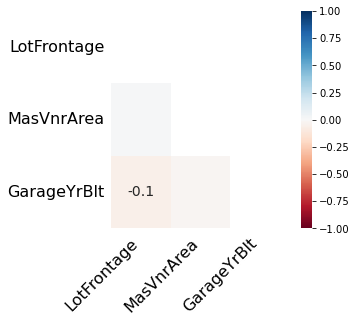

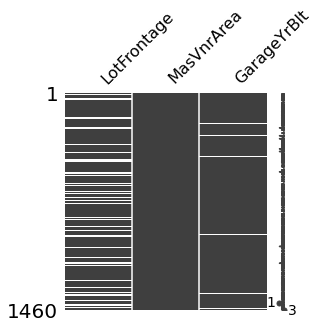

In [211]:
df = fill_missing_values_by_data_description(df)
cols_with_missing = find_cols_with_missing(df)
show_missingness(df[cols_with_missing])

In [216]:
missing_lf = df['LotFrontage'].isna()
df[['Alley', 'LotFrontage']][missing_lf]

,Alley,LotFrontage
Id,,
8,NA,NaN
13,NA,NaN
15,NA,NaN
17,NA,NaN
25,NA,NaN
...,...,...
1430,NA,NaN
1432,NA,NaN
1442,NA,NaN


There is a slight correlation between the missingness of `LotFrontage` and `GarageYrBlt`. However, we can assume that the missingness mechanism is MCAR, since the correlation is weak.

In [ ]:
df.hist(figsize=(32, 32));
plt.show();

## Feature selection

`Street` variable is a subset of `Alley` variable, hence, we can drop it without losing any information.

As we will predict the neighborhood of building, we don't need variables related to the sale of the property.

## Training

In [250]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def make_preprocessor(x_train: pd.DataFrame):
    numericals = set(x_train.select_dtypes('float').columns)
    numerical_col_indices = [i for i, col in enumerate(x_train.columns) if col in numericals]

    skewness = x_train[numericals].skew()
    sym_numericals = set(skewness[skewness.abs() <= 0.5].index)
    skw_numericals = set(numericals).difference(sym_numericals)

    sym_col_indices = [i for i, col in enumerate(x_train.columns) if col in sym_numericals]
    skw_col_indices = [i for i, col in enumerate(x_train.columns) if col in skw_numericals]

    categs = set(x_train.columns).difference(numericals)
    categ_col_indices = [i for i, col in enumerate(x_train.columns) if col in categs]

    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        (
            'scaler', 
             ColumnTransformer([
                ('scaler_sym', StandardScaler(), sym_col_indices),
                ('scaler_skw', MinMaxScaler(), skw_col_indices),
             ])
        ),
        ('pca', PCA())
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        # ('ordinal_encoder', OrdinalEncoder()),
        # ('feat_selection', SelectKBest(chi2)),
        ('onehot_encoder', OneHotEncoder(handle_unknown='ignore')),
    ])

    preprocessor = ColumnTransformer([
        ('numerical', numeric_transformer, numerical_col_indices),
        ('categorical', categorical_transformer, categ_col_indices)
    ])
    return preprocessor

In [251]:
target_variable = 'OverallQual'

df = cleanup_dataset(df, [target_variable])
x_train = df.drop(columns=[target_variable])

categs = x_train.select_dtypes('O').columns.tolist()
numericals = x_train.select_dtypes('number').columns.tolist()

x_train, y_train = prepare_dataset(df, targets=[target_variable], numericals=numericals, categs=categs)
x_test, y_test = prepare_dataset(test_df, targets=[target_variable], numericals=numericals, categs=categs)


In [252]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score

def make_searcher(estimator, param_grid, cv=5, score_averaging = 'weighted', seed=42):
    return GridSearchCV(
        estimator = estimator, 
        param_grid = param_grid,
        scoring = {
            'precision': make_scorer(precision_score, average=score_averaging), 
            'recall': make_scorer(recall_score, average=score_averaging),
            'accuracy': 'accuracy'
        }, 
        refit = 'accuracy',
        cv = cv, # number of folds for cross validation
        verbose=0, 
        n_jobs = -1
    )

In [253]:
import json

def fmt_search_results(search):
    sdf = pd.DataFrame(search.cv_results_)
    cols2keep = [col for col in sdf.columns if col=='params' or col.startswith('split')]
    sdf = sdf[cols2keep]
    sdf.columns = pd.MultiIndex.from_tuples([(np.nan, col) if col=='params' else (col[:6], col[12:]) for col in sdf.columns])
    sdf = (sdf.stack(0)
       .ffill()
       .reset_index()
       .drop(columns=['level_0'])
       .dropna(how='any', axis=0)
       .rename(columns={"level_1": "split"})
      )
    
    sdf['estimator_name'] = search.estimator.steps[-1][-1].__class__.__name__
    sdf['best_estimator'] = search.best_estimator_
    return sdf[['estimator_name', 'params', 'split', 'accuracy', 'precision', 'recall', 'best_estimator']]

In [254]:
def average_over_splits(sdf):
    return (sdf.assign(params=lambda x: x['params'].apply(str))
            .groupby(['estimator_name', 'params'])
            .agg({
                'accuracy': np.mean,
                'precision': np.mean,
                'recall': np.mean,
                'best_estimator': lambda g: next(iter(g)),
            })
            .sort_values(by='accuracy', ascending=False))

In [273]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

model_param_grids = [
    (
        RandomForestClassifier(), 
        dict(
            preprocessor__numerical__pca__n_components=[3,5,7,11],
            # preprocessor__categorical__feat_selection__k=[10, 20, 30],
            model__min_samples_leaf = [3, 10],
            model__n_estimators = [40],
            model__max_features=['auto'],
        )
    ),
]

sdf = pd.concat([
    fmt_search_results(
        make_searcher(Pipeline([('preprocessor', make_preprocessor(x_train)), ('model', model)]), pg)
            .fit(x_train, y_train.values.ravel())
    ) 
    for (model, pg) in model_param_grids
])

/Users/bdsaglam/miniconda3/envs/di501/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bdsaglam/miniconda3/envs/di501/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bdsaglam/miniconda3/envs/di501/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bdsaglam/miniconda

In [274]:
avg_score_df = average_over_splits(sdf)
avg_score_df

accuracy  \
estimator_name         params                                                         
RandomForestClassifier {'model__max_features': 'auto', 'model__min_sam...  0.564384   
                       {'model__max_features': 'auto', 'model__min_sam...  0.563699   
                       {'model__max_features': 'auto', 'model__min_sam...  0.557534   
                       {'model__max_features': 'auto', 'model__min_sam...  0.554795   
                       {'model__max_features': 'auto', 'model__min_sam...  0.552055   
                       {'model__max_features': 'auto', 'model__min_sam...  0.547260   
                       {'model__max_features': 'auto', 'model__min_sam...  0.543151   
                       {'model__max_features': 'auto', 'model__min_sam...  0.542466   

                                                                           precision  \
estimator_name         params                                                          
RandomForestClassifier {'model__max_features': 'auto', 'model__min_sam...   0.528886   
                       {'model__max_features': 'auto', 'model__min_sam...   0.533603   
                       {'model__max_features': 'auto', 'model__min_sam...   0.525980   
                       {'model__max_features': 'auto', 'model__min_sam...   0.500598   
                       {'model__max_features': 'auto', 'model__min_sam...   0.530098   
                       {'model__max_features': 'auto', 'model__min_sam...   0.508082   
                       {'model__max_features': 'auto', 'model__min_sam...   0.494788   
                       {'model__max_features': 'auto', 'model__min_sam...   0.487473   

                                                                             recall  \
estimator_name         params                                                         
RandomForestClassifier {'model__max_features': 'auto', 'model__min_sam...  0.564384   
                       {'model__max_features': 'auto', 'model__min_sam...  0.563699   
                       {'model__max_features': 'auto', 'model__min_sam...  0.557534   
                       {'model__max_features': 'auto', 'model__min_sam...  0.554795   
                       {'model__max_features': 'auto', 'model__min_sam...  0.552055   
                       {'model__max_features': 'auto', 'model__min_sam...  0.547260   
                       {'model__max_features': 'auto', 'model__min_sam...  0.543151   
                       {'model__max_features': 'auto', 'model__min_sam...  0.542466   

                                                                                                              best_estimator  
estimator_name         params                                                                                                 
RandomForestClassifier {'model__max_features': 'auto', 'model__min_sam...  (ColumnTransformer(transformers=[('numerical',...  
                       {'model__max_features': 'auto', 'model__min_sam...  (ColumnTransformer(transformers=[('numerical',...  
                       {'model__max_features': 'auto', 'model__min_sam...  (ColumnTransformer(transformers=[('numerical',...  
                       {'model__max_features': 'auto', 'model__min_sam...  (ColumnTransformer(transformers=[('numerical',...  
                       {'model__max_features': 'auto', 'model__min_sam...  (ColumnTransformer(transformers=[('numerical',...  
                       {'model__max_features': 'auto', 'model__min_sam...  (ColumnTransformer(transformers=[('numerical',...  
                       {'model__max_features': 'auto', 'model__min_sam...  (ColumnTransformer(transformers=[('numerical',...  
                       {'model__max_features': 'auto', 'model__min_sam...  (ColumnTransformer(transformers=[('numerical',...

In [275]:
m = sdf.reset_index().loc[0, 'best_estimator']

In [258]:
# m.set_params(
#     preprocessor__numerical__pca__n_components=7,
#     preprocessor__categorical__feat_selection__k=30,
#     model__min_samples_leaf = 3,
#     model__n_estimators = 40,
#     model__max_features='auto',
# )
# m = m.fit(x_train, y_train)

In [260]:
feat_selector = m.named_steps['preprocessor'].transformers_[1][1].named_steps['feat_selection']

In [261]:
feat_selector.get_support()

array([False,  True, False,  True,  True,  True,  True, False,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True])

In [195]:
feat_selector.get_feature_names_out()

array(['BldgType', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'BsmtQual', 'Condition1', 'Electrical', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'HeatingQC',
       'HouseStyle', 'KitchenQual', 'LandContour', 'LandSlope',
       'LotConfig', 'LotShape', 'MSZoning', 'MasVnrType', 'PavedDrive',
       'RoofMatl', 'RoofStyle', 'Utilities'], dtype=object)

In [196]:
feat_selector.feature_names_in_

array(['Alley', 'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'BsmtQual', 'CentralAir', 'Condition1',
       'Condition2', 'Electrical', 'ExterCond', 'ExterQual',
       'Exterior1st', 'Exterior2nd', 'Fence', 'FireplaceQu', 'Foundation',
       'Functional', 'GarageCond', 'GarageFinish', 'GarageQual',
       'GarageType', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenQual',
       'LandContour', 'LandSlope', 'LotConfig', 'LotShape', 'MSZoning',
       'MasVnrType', 'MiscFeature', 'PavedDrive', 'PoolQC', 'RoofMatl',
       'RoofStyle', 'Utilities'], dtype=object)

In [276]:
rf = m.steps[1][1]

<BarContainer object of 253 artists>

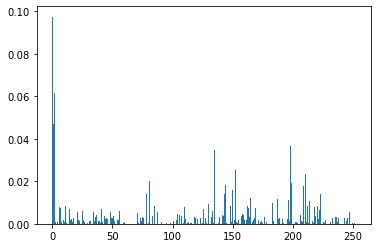

In [277]:
plt.bar(range(len(rf.feature_importances_)), rf.feature_importances_)

## Evaluation

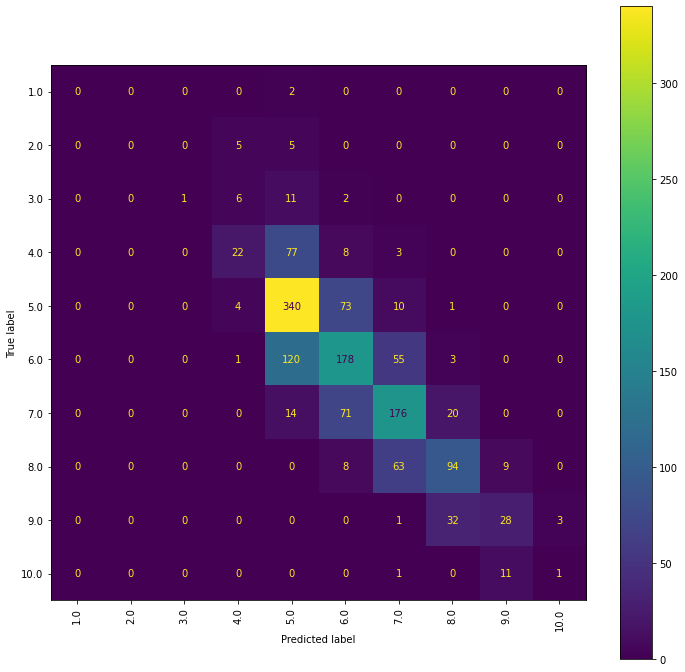

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00         2
         2.0       0.00      0.00      0.00        10
         3.0       1.00      0.05      0.10        20
         4.0       0.58      0.20      0.30       110
         5.0       0.60      0.79      0.68       428
         6.0       0.52      0.50      0.51       357
         7.0       0.57      0.63      0.60       281
         8.0       0.63      0.54      0.58       174
         9.0       0.58      0.44      0.50        64
        10.0       0.25      0.08      0.12        13

    accuracy                           0.58      1459
   macro avg       0.47      0.32      0.34      1459
weighted avg       0.57      0.58      0.56      1459



In [278]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

y_pred = m.predict(x_test.values)
cm = confusion_matrix(y_test.values.ravel(), y_pred, labels=m.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=m.classes_)
fig, ax = plt.subplots(figsize=(12,12))
disp.plot(ax=ax)
ax.xaxis.set_tick_params(rotation=90)
plt.show()
print(classification_report(y_test, y_pred))

In [ ]:
corr = odf.corr()
plt.subplots(figsize=(15,12))
sns.heatmap(corr, vmin=-1, vmax=1, cmap=sns.color_palette("vlag", as_cmap=True), square=True)

In [ ]:
tab = pd.crosstab(df['PoolQC'], df['Neighborhood'])
tab

In [ ]:
z, p, dof, ex = stats.chi2_contingency(tab)
print("p value:%.4f" % p)
if p < 0.05:    
    print("Reject null hypothesis >> dependent")
else:
    print("Fail to reject null hypothesis >> independent")

In [ ]:
x_train[categs] = x_train[categs].apply(lambda x: x.cat.codes)

In [ ]:
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

x_train[categs] = x_train[categs].apply(lambda x: x.cat.codes)
y_train = y_train.cat.codes
x_train_red = SelectKBest(chi2, k=2).fit_transform(x_train, y_train)
x_train_red.shape


In [ ]:
y_train.cat.codes

In [ ]:
x_train.values

In [ ]:
sns.pairplot(df[numericals[:3] + [target_variable]], hue=target_variable)

<h3 style="margin-bottom:0">3) PCA</h3>

For the following use mushroom data.

    a) Apply PCA to feature columns (x1..x40) and find the principal components.
    b) Plot explained variance ratios for the principal components.
    c) Determine the most appropriate number of principal components to represent the features in a lower dimensional space while preserving as much information as possible.
    d) Apply the two best performing algorithms above on the new dataset that is created by PCA. Did your algorithm's accuracy improve? Comment.

Let's apply PCA over numerical variables.

In [ ]:
def make_preprocessor_without_categs():
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        (
            'scaler', 
             ColumnTransformer([
                ('scaler_sym', StandardScaler(), sym_col_indices),
                ('scaler_skewed', MinMaxScaler(), skewed_col_indices),
             ])
        )
    ])
    preprocessor = ColumnTransformer([
        ('numerical', numeric_transformer, numerical_col_indices),
        
    ])
    return preprocessor

In [ ]:
from sklearn.decomposition import PCA

ppca = Pipeline([
    ('preprocessor', make_preprocessor_without_categs()), 
    ('pca', PCA()), 
])
pca = ppca.steps[1][1]
x_train_nums_pca = ppca.fit_transform(x_train[numericals].values)

In [ ]:
icomps = range(1, x_train_nums_pca.shape[-1]+1)
vrs = pca.explained_variance_ratio_

plt.figure(figsize=(16, 8))
plt.bar(icomps, vrs)
plt.xticks(icomps)
for icomp, vr in zip(icomps, vrs):
    plt.annotate(f'{vr:.1%}', xy=(icomp, vr), ha='center', va='bottom')

In [ ]:
cvrs = np.cumsum(vrs)

plt.figure(figsize=(16, 8))
plt.plot(icomps, cvrs)
plt.xticks(icomps)
for icomp, vr in zip(icomps, cvrs):
    plt.annotate(f'{vr:.1%}', xy=(icomp-0.2, vr+0.005), ha='center', va='bottom')

5 components covers ~97.2% of variance in the training set, hence, it's a reasonable number of components for dimensionality reduction with PCA.

Let's train best two algorithms `LogisticRegression` and `DecisionTreeClassifier` with different number of PCA components.

In [ ]:
def make_preprocessor_with_pca_reduction():
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='mean')),
        (
            'scaler', 
             ColumnTransformer([
                ('scaler_sym', StandardScaler(), sym_col_indices),
                ('scaler_skewed', MinMaxScaler(), skewed_col_indices),
             ])
        ),
        ('pca', PCA())
    ])
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=-1)),
        ('onehot_encoder', OneHotEncoder(handle_unknown='ignore'))
    ])
    preprocessor = ColumnTransformer([
        ('numerical', numeric_transformer, numerical_col_indices),
        ('categorical', categorical_transformer, categ_col_indices),
    ])
    return preprocessor

In [ ]:
model_param_grids = [
    (DecisionTreeClassifier(), dict(model__min_samples_leaf = [10], preprocessor__numerical__pca__n_components=[3,5,7])),
    (LogisticRegression(max_iter=1000), dict(model__C=[1.5], preprocessor__numerical__pca__n_components=[3,5,7]))
]

psdf = pd.concat([
    fmt_search_results(
        make_searcher(Pipeline([('preprocessor', make_preprocessor_with_pca_reduction()), ('model', model)]), pg)
            .fit(x_train, y_train.values.ravel())
    ) 
    for (model, pg) in model_param_grids
])

In [ ]:
average_over_splits(psdf)

The classification scores dropped with reduced dataset for both algorithms.

In [ ]:
corr = odf.corr()
corr.style.background_gradient(cmap='coolwarm')